In [3]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_parquet("data/user_stats_df_output.parquet")


In [7]:


# Calcul du nombre total d'achats en utilisant la valeur totale des achats divisée par le prix moyen sur 7 mois
df['total_purchases'] = df['total_purchase_value'] / df['avg_price_7m']
df['total_purchases'] = df['total_purchases'].fillna(0).astype(int)  # Conversion en entier et gestion des NaN


In [8]:
# Calcul de la valeur moyenne d'achat, évite la division par zéro en utilisant np.where
df['avg_purchase_value'] = np.where(df['total_purchases'] > 0, df['total_purchase_value'] / df['total_purchases'], 0)


In [9]:
# Calcul du taux de conversion en pourcentage
df['conversion_rate'] = np.where(df['number_of_carts_7m'] > 0, df['total_purchases'] / df['number_of_carts_7m'], 0)

In [10]:
# Supposons une période d'observation de 30 jours (1 mois environ)
observation_period_days = 30
df['purchase_frequency'] = df['total_purchases'] / observation_period_days

In [11]:
# Calcul d'un score de fidélité simplifié
df['loyalty_score'] = (df['purchase_frequency'] * 0.5) + (df['avg_purchase_value'] * 0.3) - (df['days_since_last_purchase'] * 0.2)


eps: 1.50, min_samples: 3, clusters: 1, noise points: 24
eps: 1.50, min_samples: 4, clusters: 2, noise points: 24
Silhouette Score: 0.85
eps: 1.50, min_samples: 5, clusters: 1, noise points: 27
eps: 1.50, min_samples: 6, clusters: 1, noise points: 29
eps: 1.50, min_samples: 7, clusters: 1, noise points: 35
eps: 1.50, min_samples: 8, clusters: 1, noise points: 35
eps: 1.50, min_samples: 10, clusters: 1, noise points: 37
eps: 1.50, min_samples: 12, clusters: 1, noise points: 37
eps: 1.60, min_samples: 3, clusters: 2, noise points: 20
Silhouette Score: 0.87
eps: 1.60, min_samples: 4, clusters: 1, noise points: 23
eps: 1.60, min_samples: 5, clusters: 1, noise points: 26
eps: 1.60, min_samples: 6, clusters: 1, noise points: 27
eps: 1.60, min_samples: 7, clusters: 1, noise points: 30
eps: 1.60, min_samples: 8, clusters: 1, noise points: 33
eps: 1.60, min_samples: 10, clusters: 1, noise points: 34
eps: 1.60, min_samples: 12, clusters: 1, noise points: 35
eps: 1.70, min_samples: 3, clusters: 2

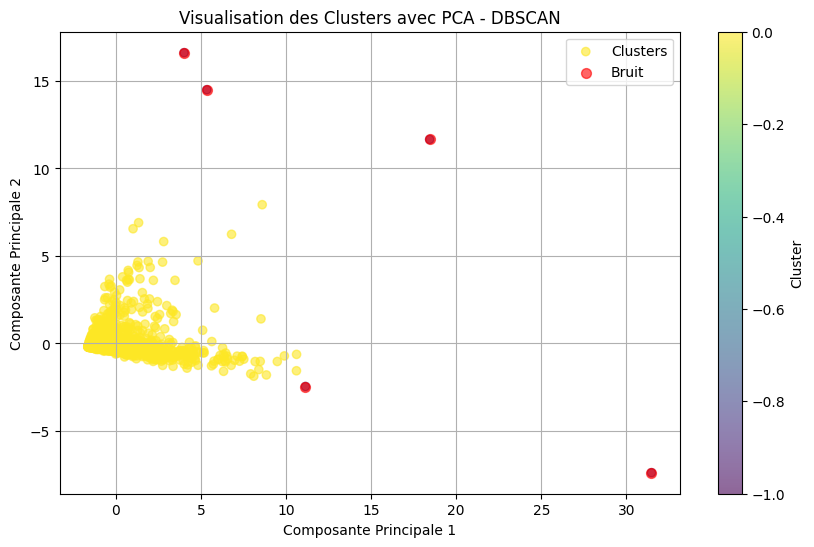

20

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import gc

# Sélection des variables pour le clustering
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    'loyalty_score',
    'total_purchase_value',
    'conversion_rate'
]


# Filtrer et normaliser les données
X = df[variables_pour_clustering].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Limiter la taille de l'échantillon pour tester
sample_size = 5000
X_sample = X_scaled[:sample_size]

# Affiner les plages de valeurs pour `eps` et `min_samples`
eps_values = [0.1 * i for i in range(15, 40)]  # Va de 1.5 à 4 avec un pas de 0.1
min_samples_values = [3, 4, 5, 6, 7, 8, 10, 12]  # Tester différentes tailles de voisinages

best_score = -1
best_eps = None
best_min_samples = None

# Tester plusieurs combinaisons de paramètres
for eps in eps_values:
    for min_samples in min_samples_values:
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_sample)
            num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            num_noise = list(clusters).count(-1)
            print(f"eps: {eps:.2f}, min_samples: {min_samples}, clusters: {num_clusters}, noise points: {num_noise}")

            # Calculer le score silhouette si plusieurs clusters sont trouvés
            if num_clusters > 1:
                score = silhouette_score(X_sample[clusters != -1], clusters[clusters != -1])
                print(f"Silhouette Score: {score:.2f}")

                # Mémoriser les meilleurs paramètres
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

            # Nettoyer la mémoire après chaque itération
            gc.collect()

        except Exception as e:
            print(f"Erreur avec eps={eps:.2f}, min_samples={min_samples}: {e}")

# Si aucun score valide n'est trouvé, définir des valeurs par défaut
if best_eps is None or best_min_samples is None:
    print("Aucun score silhouette valide trouvé, utilisation des valeurs par défaut.")
    best_eps = 1.5
    best_min_samples = 3

print(f"Meilleur eps: {best_eps}, Meilleur min_samples: {best_min_samples}, Meilleur Score Silhouette: {best_score:.2f}")

# Appliquer DBSCAN avec les meilleurs paramètres trouvés
# Limiter à un échantillon pour éviter le crash du noyau
try:
    visual_sample_size = 2000  # Réduire la taille à 2000 points pour la visualisation
    X_scaled_visual = X_scaled[:visual_sample_size]  # Restreindre l'échantillon pour DBSCAN
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    clusters = dbscan.fit_predict(X_scaled_visual)

    # Visualisation des clusters avec PCA
    X_pca = PCA(n_components=2).fit_transform(X_scaled_visual)
    clusters_sample = clusters

    # Visualiser les clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_sample, cmap='viridis', alpha=0.6, label='Clusters')
    plt.scatter(X_pca[clusters_sample == -1, 0], X_pca[clusters_sample == -1, 1], c='red', s=50, alpha=0.6, label='Bruit')
    plt.title('Visualisation des Clusters avec PCA - DBSCAN')
    plt.xlabel('Composante Principale 1')
    plt.ylabel('Composante Principale 2')
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'application de DBSCAN et de la visualisation : {e}")

# Nettoyer la mémoire après l'exécution
gc.collect()


eps: 1.00, min_samples: 3, clusters: 4, noise points: 38
Silhouette Score: 0.76
eps: 1.00, min_samples: 4, clusters: 2, noise points: 45
Silhouette Score: 0.81
eps: 1.00, min_samples: 5, clusters: 2, noise points: 48
Silhouette Score: 0.81
eps: 1.00, min_samples: 6, clusters: 1, noise points: 54
eps: 1.00, min_samples: 7, clusters: 1, noise points: 58
eps: 1.00, min_samples: 8, clusters: 1, noise points: 58
eps: 1.02, min_samples: 3, clusters: 4, noise points: 38
Silhouette Score: 0.76
eps: 1.02, min_samples: 4, clusters: 2, noise points: 45
Silhouette Score: 0.81
eps: 1.02, min_samples: 5, clusters: 2, noise points: 48
Silhouette Score: 0.81
eps: 1.02, min_samples: 6, clusters: 1, noise points: 54
eps: 1.02, min_samples: 7, clusters: 1, noise points: 57
eps: 1.02, min_samples: 8, clusters: 1, noise points: 58
eps: 1.04, min_samples: 3, clusters: 4, noise points: 38
Silhouette Score: 0.76
eps: 1.04, min_samples: 4, clusters: 3, noise points: 41
Silhouette Score: 0.76
eps: 1.04, min_sam

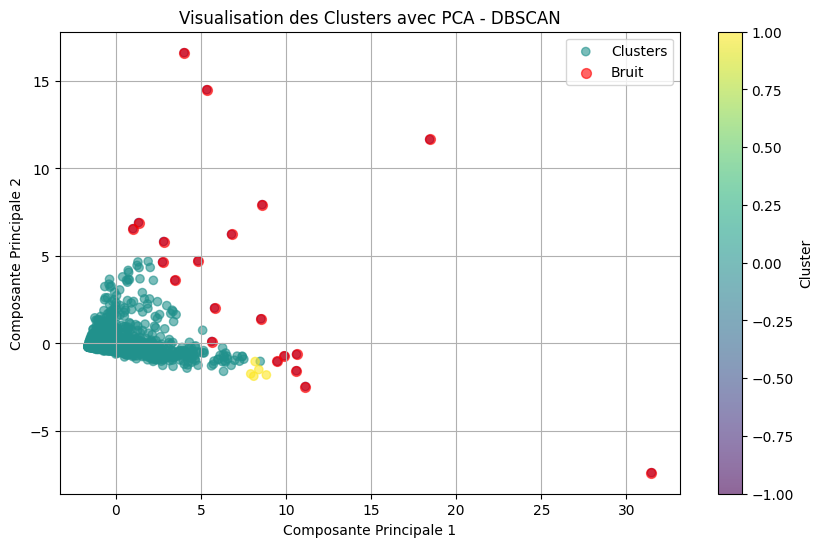

7063

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import gc



# Sélection des variables pour le clustering
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    
    'total_purchase_value',
    
]

# Filtrer et normaliser les données
X = df[variables_pour_clustering].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Limiter la taille de l'échantillon pour tester
sample_size = 5000
X_sample = X_scaled[:sample_size]

# Affiner les plages de valeurs pour `eps` et `min_samples`
eps_values = [0.02 * i for i in range(50, 75)]  # Va de 1.0 à 1.5 avec un pas de 0.02
min_samples_values = [3, 4, 5, 6, 7, 8]  # Tester différentes tailles de voisinages




best_score = -1
best_eps = None
best_min_samples = None

# Tester plusieurs combinaisons de paramètres
for eps in eps_values:
    for min_samples in min_samples_values:
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_sample)
            num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            num_noise = list(clusters).count(-1)
            print(f"eps: {eps:.2f}, min_samples: {min_samples}, clusters: {num_clusters}, noise points: {num_noise}")

            # Calculer le score silhouette si plusieurs clusters sont trouvés
            if num_clusters > 1:
                score = silhouette_score(X_sample[clusters != -1], clusters[clusters != -1])
                print(f"Silhouette Score: {score:.2f}")

                # Mémoriser les meilleurs paramètres
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

            # Nettoyer la mémoire après chaque itération
            gc.collect()

        except Exception as e:
            print(f"Erreur avec eps={eps:.2f}, min_samples={min_samples}: {e}")

# Si aucun score valide n'est trouvé, définir des valeurs par défaut
if best_eps is None or best_min_samples is None:
    print("Aucun score silhouette valide trouvé, utilisation des valeurs par défaut.")
    best_eps = 1.5
    best_min_samples = 3

print(f"Meilleur eps: {best_eps}, Meilleur min_samples: {best_min_samples}, Meilleur Score Silhouette: {best_score:.2f}")

# Appliquer DBSCAN avec les meilleurs paramètres trouvés
# Limiter à un échantillon pour éviter le crash du noyau
try:
    visual_sample_size = 2000  # Réduire la taille à 2000 points pour la visualisation
    X_scaled_visual = X_scaled[:visual_sample_size]  # Restreindre l'échantillon pour DBSCAN
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    clusters = dbscan.fit_predict(X_scaled_visual)

    # Visualisation des clusters avec PCA
    X_pca = PCA(n_components=2).fit_transform(X_scaled_visual)
    clusters_sample = clusters

    # Visualiser les clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_sample, cmap='viridis', alpha=0.6, label='Clusters')
    plt.scatter(X_pca[clusters_sample == -1, 0], X_pca[clusters_sample == -1, 1], c='red', s=50, alpha=0.6, label='Bruit')
    plt.title('Visualisation des Clusters avec PCA - DBSCAN')
    plt.xlabel('Composante Principale 1')
    plt.ylabel('Composante Principale 2')
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'application de DBSCAN et de la visualisation : {e}")

# Nettoyer la mémoire après l'exécution
gc.collect()